# Training Mask R-CNN 

Code to train Mask-RCNN for leaf segmentation

##Download the workshop git repo to access the mask-rcnn software library and the dataset

In [1]:
!pip install imgaug
!pip install Cython
!pip install pycocotools


import time
import imgaug
import cv2
import datetime
import skimage.draw
import os
import sys
import itertools
import math
import logging
import json
import re
import random
from collections import OrderedDict
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.lines as lines
from matplotlib.patches import Polygon

%matplotlib inline


**Change to the workshop working directory**

In [2]:
os.chdir('/content')
!rm -rf Mask_RCNN
!git clone https://github.com/aneeshchauhan/Mask_RCNN

Cloning into 'Mask_RCNN'...
remote: Enumerating objects: 4, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 2706 (delta 0), reused 1 (delta 0), pack-reused 2702
Receiving objects: 100% (2706/2706), 119.58 MiB | 30.38 MiB/s, done.
Resolving deltas: 100% (610/610), done.


**Setup to start using the library**

In [3]:
os.chdir('/content/Mask_RCNN/samples')

!pwd

/content/Mask_RCNN/samples


**Setup to start using the library**

In [4]:
# Root directory of the project
ROOT_DIR = os.path.abspath("../")
print(ROOT_DIR)
# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library

from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
from mrcnn.model import log
from mrcnn.config import Config
from mrcnn import model as modellib, utils


from samples.leaf import leaf

/content/Mask_RCNN


Using TensorFlow backend.


**Setup necessary paths and download the pretrained model**

The pretrained Mask-RCNN model was trained on coco dataset

In [5]:
#Root directory of the project
DATASET_DIR = '../datasets/Ara2013-Canon'

# Import Mask RCNN
from mrcnn.config import Config

# Path to trained weights file
COCO_WEIGHTS_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")

# Directory to save logs and model checkpoints, if not provided
# through the command line argument --logs

#Options are coco or imagenet
# WHICH_WEIGHTS = 'imagenet'
WHICH_WEIGHTS = 'coco'
DEFAULT_LOGS_DIR = os.path.join(ROOT_DIR, "logs/coco_heads")

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

... done downloading pretrained model!


#Configuration
Parameters to tune for the training algorithm

In [0]:
############################################################
#  Configurations
############################################################

    
EPOCHS = 20
# EPOCHS = 100

class LeafConfig(Config):
    """Configuration for training on the toy  dataset.
    Derives from the base Config class and overrides some values.
    """
    # Give the configuration a recognizable name
    NAME = "leaf"
    
    # Supported values are: resnet50, resnet101.
    BACKBONE = "resnet50"
    
    
    # Max number of final detections
    DETECTION_MAX_INSTANCES = 100
    
#     LEARNING_RATE = 0.005
    LEARNING_RATE = 0.0021
    LEARNING_MOMENTUM = 0.9

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)  # anchor side in pixels
    

    IMAGE_MIN_DIM = 128
    IMAGE_MAX_DIM = 128


    # We use a GPU with 12GB memory, which can fit two images.
    # Adjust down if you use a smaller GPU.
    IMAGES_PER_GPU = 4

    # Number of classes (including background)
    NUM_CLASSES = 1 + 1  # Background + leaf

    # Number of training steps per epoch
#     STEPS_PER_EPOCH = 200
    STEPS_PER_EPOCH = 20

    # Skip detections with < 90% confidence
    DETECTION_MIN_CONFIDENCE = 0.9

####Training function defines and setup the training and validation configurations

In [0]:
def train(model):
    """Train the model."""
    # Training dataset.
    dataset_train = leaf.LeafDataset()
    dataset_train.load_leaf(DATASET_DIR, "train")
    dataset_train.prepare()

    # Validation dataset
    dataset_val = leaf.LeafDataset()
    dataset_val.load_leaf(DATASET_DIR, "val")
    dataset_val.prepare()

    # *** This training schedule is an example. Update to your needs ***
    # Since we're using a very small dataset, and starting from
    # COCO trained weights, we don't need to train too long. Also,
    # no need to train all layers, just the heads should do it.
    print("Training network heads")
    model.train(dataset_train, dataset_val,
                learning_rate=config.LEARNING_RATE,
                epochs=EPOCHS,
#                 layers = 'all',
                layers='heads',
                augmentation = imgaug.augmenters.Sometimes(0.5, [
                    imgaug.augmenters.Fliplr(0.5),
                    imgaug.augmenters.GaussianBlur(sigma=(0.0, 3.0))
                ])
               )

#Configure the network and train

In [8]:
config = LeafConfig()
model = modellib.MaskRCNN(mode="training", config=config, model_dir=DEFAULT_LOGS_DIR)

W0709 18:26:20.812405 140661265414016 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0709 18:26:20.833567 140661265414016 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0709 18:26:20.858870 140661265414016 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0709 18:26:20.884160 140661265414016 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:1919: The name tf.nn.fused_batch_norm is deprecated. Please use tf.compat.v1.nn.fused_batch_norm instead.

W0709 18:26:20.887258 140661265

In [0]:
weights_path = None
if WHICH_WEIGHTS == "coco":
    weights_path = COCO_WEIGHTS_PATH
    # Exclude the last layers because they require a matching
    # number of classes
    model.load_weights(weights_path, by_name=True, exclude=[
            "mrcnn_class_logits", "mrcnn_bbox_fc",
            "mrcnn_bbox", "mrcnn_mask"])
else:
    weights_path = model.get_imagenet_weights()
    model.load_weights(weights_path, by_name=True)

In [10]:
train(model)

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Image_DIR:  ../datasets/Ara2013-Canon/train/images
Class ids [1]
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Image_DIR:  ../datasets/Ara2013-Canon/val/images
Class ids [1]
Training network heads

Starting at epoch 0. LR=0.0021

Checkpoint Path: /content/Mask_RCNN/logs/coco_heads/leaf_model/mask_rcnn_leaf_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         

W0709 18:26:30.447121 140661265414016 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Co

Epoch 1/10
20/20 [==============================] - 75s 4s/step - loss: 2.7888 - rpn_class_loss: 0.1504 - rpn_bbox_loss: 0.9635 - mrcnn_class_loss: 0.1378 - mrcnn_bbox_loss: 0.7421 - mrcnn_mask_loss: 0.7950 - val_loss: 2.3436 - val_rpn_class_loss: 0.1158 - val_rpn_bbox_loss: 0.9054 - val_mrcnn_class_loss: 0.0768 - val_mrcnn_bbox_loss: 0.6766 - val_mrcnn_mask_loss: 0.5690
Epoch 2/10
20/20 [==============================] - 37s 2s/step - loss: 2.0915 - rpn_class_loss: 0.0948 - rpn_bbox_loss: 0.8023 - mrcnn_class_loss: 0.1077 - mrcnn_bbox_loss: 0.5180 - mrcnn_mask_loss: 0.5686 - val_loss: 1.8426 - val_rpn_class_loss: 0.0986 - val_rpn_bbox_loss: 0.8004 - val_mrcnn_class_loss: 0.0720 - val_mrcnn_bbox_loss: 0.4225 - val_mrcnn_mask_loss: 0.4491
Epoch 3/10
20/20 [==============================] - 37s 2s/step - loss: 1.9238 - rpn_class_loss: 0.0921 - rpn_bbox_loss: 0.8459 - mrcnn_class_loss: 0.1049 - mrcnn_bbox_loss: 0.4357 - mrcnn_mask_loss: 0.4452 - val_loss: 1.8101 - val_rpn_class_loss: 0.09

#Inference

In [24]:
#Sanity check that training snapshots are saved
!ls ../logs/coco_heads/leaf_model

events.out.tfevents.1562696797.423fd41621a5  mask_rcnn_leaf_0006.h5
mask_rcnn_leaf_0001.h5			     mask_rcnn_leaf_0007.h5
mask_rcnn_leaf_0002.h5			     mask_rcnn_leaf_0008.h5
mask_rcnn_leaf_0003.h5			     mask_rcnn_leaf_0009.h5
mask_rcnn_leaf_0004.h5			     mask_rcnn_leaf_0010.h5
mask_rcnn_leaf_0005.h5


In [0]:
# Override the training configurations with a few
# changes for inferencing.
class InferenceConfig(config.__class__):
    # Run detection on one image at a time
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
# config.display()

In [0]:
# Device to load the neural network on.
# Useful if you're training a model on the same 
# machine, in which case use CPU and leave the
# GPU for training.
DEVICE = "/gpu:0"  # /cpu:0 or /gpu:0

# Inspect the model in training or inference modes
# values: 'inference' or 'training'
# TODO: code for 'training' test mode not ready yet
TEST_MODE = "inference"

In [0]:
def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

In [16]:
# Load validation dataset
dataset = leaf.LeafDataset()
dataset.load_leaf(DATASET_DIR, "val")

# Must call before using the dataset
dataset.prepare()

print("Images: {}\nClasses: {}".format(len(dataset.image_ids), dataset.class_names))

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
Image_DIR:  ../datasets/Ara2013-Canon/val/images
Class ids [1]
Images: 12
Classes: ['BG', 'leaf']


In [17]:
#Check the model directory name
ls ../logs/coco_heads/*/*

../logs/coco_heads/leaf_model/events.out.tfevents.1562696797.423fd41621a5
../logs/coco_heads/leaf_model/mask_rcnn_leaf_0001.h5
../logs/coco_heads/leaf_model/mask_rcnn_leaf_0002.h5
../logs/coco_heads/leaf_model/mask_rcnn_leaf_0003.h5
../logs/coco_heads/leaf_model/mask_rcnn_leaf_0004.h5
../logs/coco_heads/leaf_model/mask_rcnn_leaf_0005.h5
../logs/coco_heads/leaf_model/mask_rcnn_leaf_0006.h5
../logs/coco_heads/leaf_model/mask_rcnn_leaf_0007.h5
../logs/coco_heads/leaf_model/mask_rcnn_leaf_0008.h5
../logs/coco_heads/leaf_model/mask_rcnn_leaf_0009.h5
../logs/coco_heads/leaf_model/mask_rcnn_leaf_0010.h5


##Select a model to test

By default the first model is chosen, you ca chose any frm the list above

Just replace  'mask_rcnn_leaf_0001.h5' with the model of your choice

In [28]:
#Put the correct directory path here
MODEL_DIR = '../logs/coco_heads/leaf_model' 


model = modellib.MaskRCNN(mode="inference", config=config, model_dir=MODEL_DIR)
LEAF_WEIGHTS_PATH = os.path.join(MODEL_DIR, 'mask_rcnn_leaf_0001.h5')

weights_path = LEAF_WEIGHTS_PATH
print(weights_path)

../logs/coco_heads/leaf_model/mask_rcnn_leaf_0010.h5


## Load the trained weights onto the model

In [0]:
model.load_weights(weights_path, by_name=True, exclude=[
            "mrcnn_class_logits", "mrcnn_bbox_fc",
            "mrcnn_bbox", "mrcnn_mask"])

##Apply model to a radom image

image ID: leaf.2 (1) leaf.404
Processing 1 images
image                    shape: (128, 128, 3)         min:    0.00000  max:  161.00000  uint8
molded_images            shape: (1, 128, 128, 3)      min: -123.70000  max:   44.20000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  128.00000  int64
anchors                  shape: (1, 4092, 4)          min:   -0.71267  max:    1.20874  float32
gt_class_id              shape: (5,)                  min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (5, 4)                min:   16.00000  max:  111.00000  int32
gt_mask                  shape: (56, 56, 5)           min:    0.00000  max:    1.00000  bool


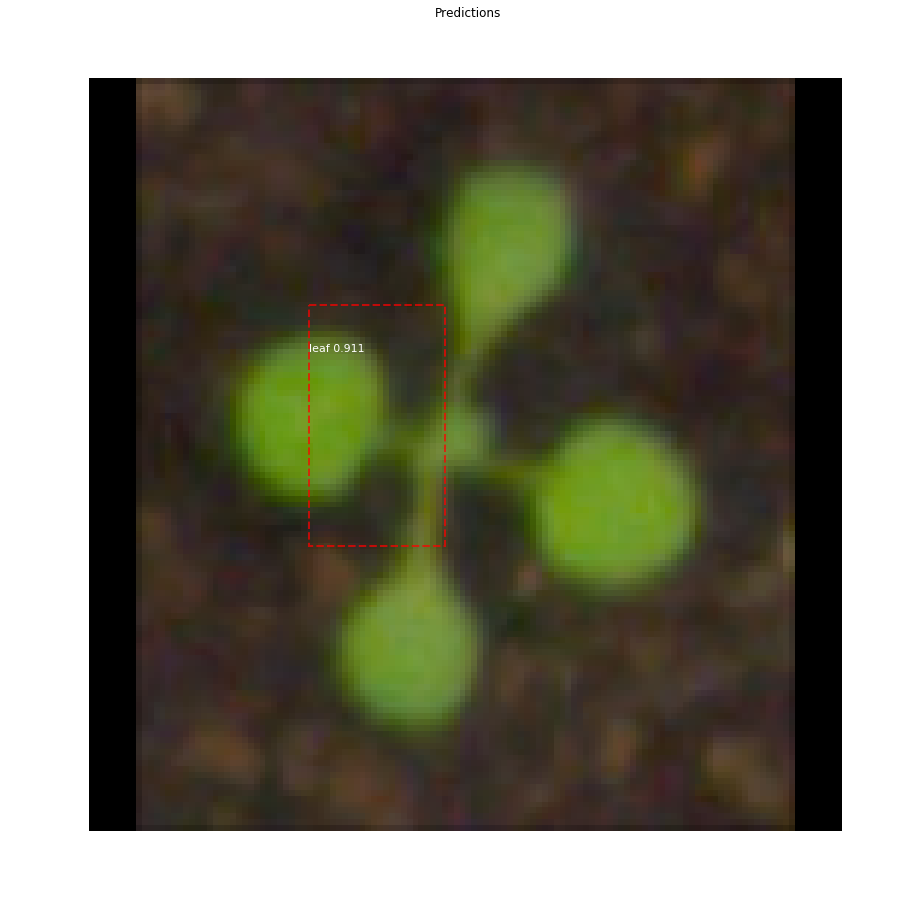

In [30]:
image_id = random.choice(dataset.image_ids)
# image_id = dataset.image_ids[0]
image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset, config, image_id, use_mini_mask=True)
info = dataset.image_info[image_id]
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                       dataset.image_reference(image_id)))
# Run object detection
results = model.detect([image], verbose=1)

# Display results
ax = get_ax(1)
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            dataset.class_names, r['scores'], ax=ax,
                            title="Predictions")
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)